In [0]:
# standard imports
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as scs

plt.style.use('ggplot')

# The Math Behind AB Testing

## Outline
1. Set up the experiment
  * What is the goal? 
  * What is the metric and how much of an increase is worth the change? 
  * How much statistical power and level of significance do you need? Typically 80% and 0.05 are used respectively.
2. Set up a control group and test group by selecting users at random
3. Run the test -> Record the success rate for each group
4. Plot the distribution of the difference between the two samples
5. Measure the probability of getting the result of the test group and the confidence interval. Check to see if there is enough statistical power and that the level of significance is achieved.
6. Consider other tradeoffs and decide if the change should be launched

## Set up the experiment

The goal of running an AB test is to evaluate if a change in a website will lead to improved performance in a specific metric. You may decide to test very simple alternatives such as changing the look of a single button on a webpage or testing different layouts and headlines. You could also run an AB test on multi-step processes which may have many differences. Examples include signing up a new user or processing the sale on an online marketplace. There are many articles on the web about AB testing but very few actually get into the math. So, the goal of this article is to provide a walkthrough of a typical AB test with equations and plots at each step.

## Variables

* Sample size
* Baseline conversion rate
* Minimum detectable effect
* Desired statistical power
* Confidence level or level of significance

## Control Group A and Test Group B
Typically, users are randomly selected and assigned to either a control group or a test group, and the total number of users participating in the A/B test make up a small percentage of the total amount of users. For this article, we will run an A/B test for a hypothetical company that is trying to get users to sign up for a premium account.

Initially, we will collect 1000 samples for each group and serve the current signup page to the control group and a new signup page to the test group.

## Run the Test

Since this is just a hypothetical case, let's generate some fake data. In real-world applications, you will have to wait the amount of time needed to gather the data.

In [0]:
# A is control; B is test
N_A = 1000
N_B = 1000

You will also not be able to set the difference, `d_hat`, prior to your experiment, like we will be doing below for our hypothetical test.

In [0]:
# bcr: baseline conversion rate
# d_hat: difference in a metric between the two groups, sometimes referred to as minimal detectable effect or lift depending on the context
p_A = 0.10
p_B = 0.12

In [0]:
def generate_data(N_A, N_B, p_A, p_B, days=None, control_label='A',
                  test_label='B'):
    """Returns a pandas dataframe with fake CTR data
    Example:
    Parameters:
        N_A (int): sample size for control group
        N_B (int): sample size for test group
            Note: final sample size may not match N_A provided because the
            group at each row is chosen at random (50/50).
        p_A (float): conversion rate; conversion rate of control group
        p_B (float): conversion rate; conversion rate of test group
        days (int): optional; if provided, a column for 'ts' will be included
            to divide the data in chunks of time
            Note: overflow data will be included in an extra day
        control_label (str)
        test_label (str)
    Returns:
        df (df)
    """

    # initiate empty container
    data = []

    # total amount of rows in the data
    N = N_A + N_B

    # distribute events based on proportion of group size
    group_bern = scs.bernoulli(N_A / (N_A + N_B))

    # initiate bernoulli distributions from which to randomly sample
    A_bern = scs.bernoulli(p_A)
    B_bern = scs.bernoulli(p_B)

    for idx in range(N):
        # initite empty row
        row = {}
        # for 'ts' column
        if days is not None:
            if type(days) == int:
                row['ts'] = idx // (N // days)
            else:
                raise ValueError("Provide an integer for the days parameter.")
        # assign group based on 50/50 probability
        row['group'] = group_bern.rvs()

        if row['group'] == 0:
            # assign conversion based on provided parameters
            row['converted'] = A_bern.rvs()
        else:
            row['converted'] = B_bern.rvs()
        # collect row into data container
        data.append(row)

    # convert data into pandas dataframe
    df = pd.DataFrame(data)

    # transform group labels of 0s and 1s to user-defined group labels
    df['group'] = df['group'].apply(
        lambda x: control_label if x == 0 else test_label)

    return df

In [0]:
ab_data = generate_data(N_A, N_B, p_A, p_B)

In [6]:
ab_data.head(5)

,group,converted
0,A,0
1,A,0
2,B,0
3,B,0
4,B,0


Let's look at some of the metrics that are immediately available. First, let's confirm the amount of rows of data.

In [7]:
ab_data.shape

(2000, 2)

Next, let's see how many users from each group converted.

In [0]:
A_group = ab_data[ab_data['group'] == 'A']
B_group = ab_data[ab_data['group'] == 'B']

In [9]:
A_converted, B_converted = A_group['converted'].sum(), B_group['converted'].sum()
A_converted, B_converted

(112, 125)

In [10]:
A_total, B_total = len(A_group), len(B_group)
A_total, B_total

(1042, 958)

In [11]:
p_A, p_B = A_converted / A_total, B_converted / B_total
p_A, p_B

(0.10748560460652591, 0.1304801670146138)

In [12]:
p_B - p_A

0.02299456240808788

In [0]:
ab_summary = ab_data.pivot_table(values='converted', index='group', aggfunc=np.sum)
ab_summary['total'] = ab_data.pivot_table(values='converted', index='group', aggfunc=lambda x: len(x))
ab_summary['rate'] = ab_data.pivot_table(values='converted', index='group')

In [14]:
ab_summary

,converted,total,rate
group,,,
A,112,1042,0.107486
B,125,958,0.130480


The above result matches our parameters that we used to set up the test. Keep in mind that you will not be able to set how much lift you would see in the test group in real-world applications. However, you do have to decide how many samples you will need for the test and you will probably know the baseline conversion rate.

If you observe the conversion rate for both groups, you find that the new signup page resulted in an improvement of 2%. This is good news, but how can you demonstrate that this result is statistically significant.

## Compare the Two Samples

In [15]:
p_B * A_total

135.96033402922757

Text(0, 0.5, 'probability')

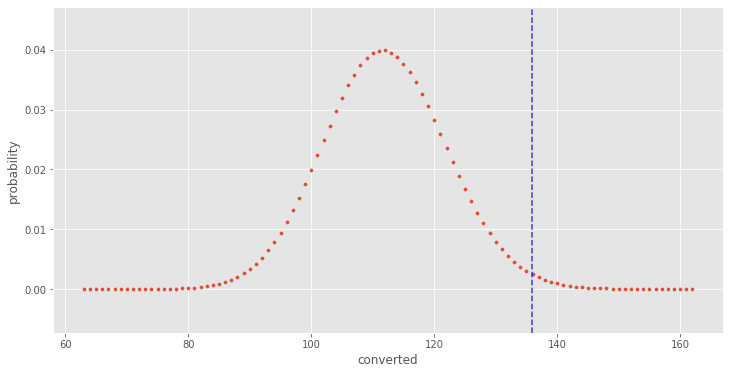

In [16]:
fig, ax = plt.subplots(figsize=(12,6))
x = np.linspace(A_converted-49, A_converted+50, 100)
y = scs.binom(A_total, p_A).pmf(x)
ax.scatter(x, y, s=10)
ax.axvline(x=p_B * A_total, c='blue', alpha=0.75, linestyle='--')
plt.xlabel('converted')
plt.ylabel('probability')

If we plot the binomial distribution that corresponds to the control group we would get the plot above in red. If we want to evaluate the probability of getting the result from the test group based on the binomial distribution from the control group, we would get the following:

In [17]:
scs.binom(A_total, p_A).pmf(116)

0.03627385118179975

That is a very low probability. If we are comparing this to a significance level, typically referred to as alpha, we would say that the result is drastically lower than 5% or even 1%. In other words, there was a 0.2% chance that we would have seen this result. Is this enough evidence of statistical significance? Let's get into statistical power.

We can plot the data from both groups as binomial distributions.

Text(0, 0.5, 'probability')

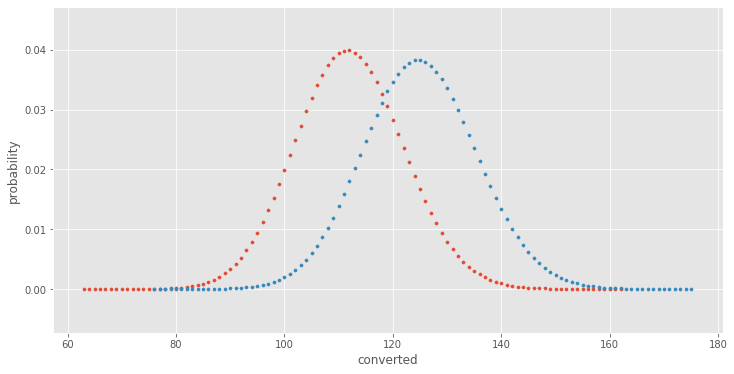

In [18]:
fig, ax = plt.subplots(figsize=(12,6))
xA = np.linspace(A_converted-49, A_converted+50, 100)
yA = scs.binom(A_total, p_A).pmf(xA)
ax.scatter(xA, yA, s=10)
xB = np.linspace(B_converted-49, B_converted+50, 100)
yB = scs.binom(B_total, p_B).pmf(xB)
ax.scatter(xB, yB, s=10)
plt.xlabel('converted')
plt.ylabel('probability')

We can see that the test group converted more users than the control group. However, the plot above is not a plot of the null and alternate hypothesis. The null hypothesis is a plot of the difference between the probability of the two groups.

In order to calculate the difference between the two groups, we need to standardize the data. Because the number of samples might be different between the two groups, we should compare the probability of successes, p.

Consider the [Bernoulli distribution](https://en.wikipedia.org/wiki/Bernoulli_distribution) for the control group.

$$ X \sim Bernoulli(p) $$
where p is the true conversion probability of the control group.

According to the properties of the Bernoulli distribution, the mean and variance are as follows:

$$ E(X) = p $$

$$ Var(X) = p(1-p) $$ 

According to the central limit theorem, by calculating many sample means we can approximate the true mean of the population from which the data for the control group was taken. The distribution of the sample means will be normally distributed around the true mean with a standard deviation equal to the [standard error of the mean](https://en.wikipedia.org/wiki/Standard_error).

The [standard error of the mean](https://en.wikipedia.org/wiki/Standard_error) is given as:

$$ \sigma_{\bar{x}} = \frac{s}{\sqrt{n}} = \frac{\sqrt{p(1-p)}}{\sqrt{n}} $$

The same can be done with the alternate group.

Therefore, we can represent both groups as a normal distribution with the following properties

$$ \hat{p} \sim Normal\left(\mu = p, \: \sigma = \frac{\sqrt{p(1-p)}}{\sqrt{n}}\right) $$

In [19]:
SE_A = np.sqrt(p_A * (1-p_A)) / np.sqrt(A_total)
SE_A

0.009595086784996161

In [20]:
SE_B = np.sqrt(p_B * (1-p_B)) / np.sqrt(B_total)
SE_B

0.010882514226876786

Text(0, 0.5, 'PDF')

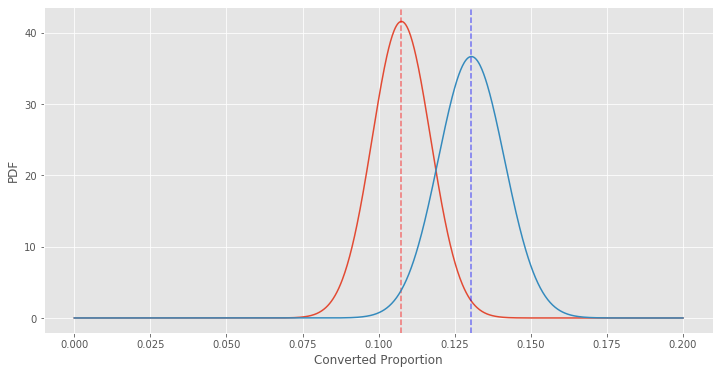

In [21]:
fig, ax = plt.subplots(figsize=(12,6))
xA = np.linspace(0, .2, 1000)
yA = scs.norm(p_A, SE_A).pdf(xA)
ax.plot(xA, yA)
ax.axvline(x=p_A, c='red', alpha=0.5, linestyle='--')

xB = np.linspace(0, .2, 1000)
yB = scs.norm(p_B, SE_B).pdf(xB)
ax.plot(xB, yB)
ax.axvline(x=p_B, c='blue', alpha=0.5, linestyle='--')

plt.xlabel('Converted Proportion')
plt.ylabel('PDF')

The dashed lines represent the mean conversion rate for each group. The distance between the red dashed line and the blue dashed line is equal to d_hat.

$$ \hat{d} = \hat{p}_B - \hat{p}_A $$

## Back to the Null and Alternate Hypothesis
Recall that the null hypothesis states that the difference in probability between the two groups is zero. We should construct a distribution of this difference, since for any A/B experiment our value for p each come from a two different distributions and the difference will have its own variance.

$$ H_0: d = 0 $$

$$ \hat{d} \sim Normal(0, \: SE_{pool}) $$

$$ H_A: d = p_B - p_A $$

$$ \hat{d} \sim Normal(d, \: SE_{pool}) $$

## Variance of the Sum
The [variance of the sum](https://en.wikipedia.org/wiki/Variance) (of two random independent variables) is the sum of the variances.

$$ Var(X + Y) = Var(X) + Var(Y) $$
$$ Var(X - Y) = Var(X) + Var(Y) $$

Because the distribution for the difference is calculated from two normal distributions, we can assume that the difference will be normally distributed.

The null hypothesis is the normal distribution of the difference with a mean of zero. 

The alternate hypothesis is the normal distribution of the difference with a mean of the difference in the means of the two groups. 

The null hypothesis and alternate hypothesis will the same variance which will be the sum of the variances for the control group and the test group.

$$ Var(\hat{d}) = Var(\hat{p}_B - \hat{p}_A) = Var(\hat{p}_A) + Var(\hat{p}_B) = \frac{p_A(1-p_A)}{n_A} + \frac{p_B(1-p_B)}{n_B} $$

The standard deviation will be the square root of the variance.

$$ \sigma = \sqrt{Var(\hat{d})} = \sqrt{ \frac{p_A(1-p_A)}{n_A} + \frac{p_B(1-p_B)}{n_B} } $$

## Pooled Variance
We can put this equation in terms of $s$, where $s$ is the standard deviation of the Bernoulli distribution.

$$ \sigma = \sqrt{Var(\hat{d})} = \sqrt{ \frac{s_A^2}{n_A} + \frac{s_B^2}{n_B} } $$

The is the [Satterthwaite approximation](http://www.statisticshowto.com/satterthwaite-approximation/) for pooled variance.

If we pool the probability like the [Udacity lesson](https://www.youtube.com/watch?v=iub8yWiO84I) and then calculate the variance for the pooled probability, we would end up with the same equation for pooled variance shown in the lesson.

$$ \sigma = \sqrt{Var(\hat{d})} = \sqrt{ \frac{s_p^2}{n_A} + \frac{s_p^2}{n_B} } = \sqrt{ s_p \left(\frac{1}{n_A} + \frac{1}{n_B} \right) } = \sqrt{ \hat{p}_p(1-\hat{p}_p) \left(\frac{1}{n_A} + \frac{1}{n_B} \right) } $$

$$ \hat{p}_p = \frac{p_A N_A + p_B N_B}{N_A + N_B} $$

### Statistical power
We now need to consider the confidence level of the test. We will plot the null hypothesis and the alternative hypothesis.

* The null hypothesis is that the change made for the test group **would result in no change** in the conversion rate.
* The alternative hypothesis is that the change for the test group **would result in a detectable change** in the conversion rate.

We can represent the null hypothesis by plotting the distribution of the difference between the control and test group. According to the Udacity course, the distribution will be normal with a mean of zero and a standard deviation equal to the pooled standard error. This is an application of the central limit theorem. 

According to statisticshowto:
The Central Limit Theorem states that the sampling distribution of the sample means approaches a normal distribution as the sample size gets larger — no matter what the shape of the population distribution.


We can prove this by the following: 
Our control and test groups are samples taken from a population. 
We are taking the mean of each group's distribution, which in this case is binomial, and we are finding the difference Let's demonstrate if this distribution is truly normal. We can use our data generation script to repeat this process 1000 times. We will set the variable, `d_hat`, to zero to represent the case where the null hypothesis is true.

### 

### Pooled Standard Error

$$ SE_p = \sqrt{\frac{s_1^2}{n_1} + \frac{s_2^2}{n_2}}$$ 

$$ SE_p = S_p\sqrt{\frac{1}{n_1} + \frac{1}{n_2}} = \sqrt{S_p^2\left(\frac{1}{n_1} + \frac{1}{n_2} \right)} = \sqrt{ p_p(1-p_p) \left(\frac{1}{n_1} + \frac{1}{n_2} \right)} $$

$$ SE_p = \sqrt{ p_p(1-p_p) \left(\frac{1}{n_1} + \frac{1}{n_2} \right)} $$

In [0]:
bcr = p_A
d_hat = p_B - p_A

In [23]:
N_A, N_B, bcr, d_hat

(1000, 1000, 0.10748560460652591, 0.02299456240808788)

In [0]:
def pooled_prob(N_A, N_B, X_A, X_B):
    """Returns pooled probability for two samples"""
    return (X_A + X_B) / (N_A + N_B)


def pooled_SE(N_A, N_B, X_A, X_B):
    """Returns the pooled standard error for two samples"""
    p_hat = pooled_prob(N_A, N_B, X_A, X_B)
    SE = np.sqrt(p_hat * (1 - p_hat) * (1 / N_A + 1 / N_B))
    return SE


def confidence_interval(sample_mean=0, sample_std=1, sample_size=1,
                        sig_level=0.05):
    """Returns the confidence interval as a tuple"""
    z = z_val(sig_level)

    left = sample_mean - z * sample_std / np.sqrt(sample_size)
    right = sample_mean + z * sample_std / np.sqrt(sample_size)

    return (left, right)


def z_val(sig_level=0.05, two_tailed=True):
    """Returns the z value for a given significance level"""
    z_dist = scs.norm()
    if two_tailed:
        sig_level = sig_level/2
        area = 1 - sig_level
    else:
        area = 1 - sig_level

    z = z_dist.ppf(area)

    return z


def ab_dist(stderr, d_hat=0, group_type='control'):
    """Returns a distribution object depending on group type
    Examples:
    Parameters:
        stderr (float): pooled standard error of two independent samples
        d_hat (float): the mean difference between two independent samples
        group_type (string): 'control' and 'test' are supported
    Returns:
        dist (scipy.stats distribution object)
    """
    if group_type == 'control':
        sample_mean = 0

    elif group_type == 'test':
        sample_mean = d_hat

    # create a normal distribution which is dependent on mean and std dev
    dist = scs.norm(sample_mean, stderr)
    return dist


def min_sample_size(bcr, mde, power=0.8, sig_level=0.05):
    """Returns the minimum sample size to set up a split test
    Arguments:
        bcr (float): probability of success for control, sometimes
        referred to as baseline conversion rate
        mde (float): minimum change in measurement between control
        group and test group if alternative hypothesis is true, sometimes
        referred to as minimum detectable effect
        power (float): probability of rejecting the null hypothesis when the
        null hypothesis is false, typically 0.8
        sig_level (float): significance level often denoted as alpha,
        typically 0.05
    Returns:
        min_N: minimum sample size (float)
    References:
        Stanford lecture on sample sizes
        http://statweb.stanford.edu/~susan/courses/s141/hopower.pdf
    """
    # standard normal distribution to determine z-values
    standard_norm = scs.norm(0, 1)

    # find Z_beta from desired power
    Z_beta = standard_norm.ppf(power)

    # find Z_alpha
    Z_alpha = standard_norm.ppf(1-sig_level/2)

    # average of probabilities from both groups
    pooled_prob = (bcr + bcr+mde) / 2

    min_N = (2 * pooled_prob * (1 - pooled_prob) * (Z_beta + Z_alpha)**2
             / mde**2)

    return min_N


def p_val(N_A, N_B, p_A, p_B):
    """Returns the p-value for an A/B test"""
    return scs.binom(N_A, p_A).pmf(p_B * N_B)

In [0]:
def plot_norm_dist(ax, mu, sig, with_CI=False, sig_level=0.05, label=None):
    """Adds a normal distribution to the axes provided
    Example:
        plot_norm_dist(ax, 0, 1)  # plots a standard normal distribution
    Parameters:
        ax (matplotlib axes)
        mu (float): mean of the normal distribution
        sig (float): standard deviation of the normal distribution
    Returns:
        None: the function adds a plot to the axes object provided
    """
    x = np.linspace(mu - 12 * sig, mu + 12 * sig, 1000)
    y = scs.norm(mu, sig).pdf(x)
    ax.plot(x, y, label=label)

    if with_CI:
        plot_CI(ax, mu, sig, sig_level=sig_level)


def plot_binom_dist(ax, n, p, label=None):
    """Adds a binomial distribution to the axes provided
    Example:
        plot_norm_dist(ax, 0, 1)  # plots a standard normal distribution
    Parameters:
        ax (matplotlib axes)
        mu (float): mean of the normal distribution
        sig (float): standard deviation of the normal distribution
    Returns:
        None: the function adds a plot to the axes object provided
    """
    x = np.linspace(0, n, n+1)
    y = scs.binom(n, p).pmf(x)
    ax.plot(x, y, label=label)


def plot_CI(ax, mu, s, sig_level=0.05, color='grey'):
    """Calculates the two-tailed confidence interval and adds the plot to
    an axes object.
    Example:
        plot_CI(ax, mu=0, s=stderr, sig_level=0.05)
    Parameters:
        ax (matplotlib axes)
        mu (float): mean
        s (float): standard deviation
    Returns:
        None: the function adds a plot to the axes object provided
    """
    # z = scs.norm().ppf(1 - sig_level/2)
    # left = mu - z * s
    # right = mu + z * s
    left, right = confidence_interval(sample_mean=mu, sample_std=s,
                                      sig_level=sig_level)
    ax.axvline(left, c=color, linestyle='--', alpha=0.5)
    ax.axvline(right, c=color, linestyle='--', alpha=0.5)


def plot_null(ax, stderr):
    """Plots the null hypothesis distribution where if there is no real change,
    the distribution of the differences between the test and the control groups
    will be normally distributed.
    The confidence band is also plotted.
    Example:
        plot_null(ax, stderr)
    Parameters:
        ax (matplotlib axes)
        stderr (float): the pooled standard error of the control and test group
    Returns:
        None: the function adds a plot to the axes object provided
    """
    plot_norm_dist(ax, 0, stderr, label="Null")
    plot_CI(ax, mu=0, s=stderr, sig_level=0.05)


def plot_alt(ax, stderr, d_hat):
    """Plots the alternative hypothesis distribution where if there is a real
    change, the distribution of the differences between the test and the
    control groups will be normally distributed and centered around d_hat
    The confidence band is also plotted.
    Example:
        plot_alt(ax, stderr, d_hat=0.025)
    Parameters:
        ax (matplotlib axes)
        stderr (float): the pooled standard error of the control and test group
    Returns:
        None: the function adds a plot to the axes object provided
    """
    plot_norm_dist(ax, d_hat, stderr, label="Alternative")
    # plot_CI(ax, mu=d_hat, s=stderr, sig_level=0.05)


def abplot(N_A, N_B, bcr, d_hat, sig_level=0.05, show_power=False,
           show_alpha=False, show_beta=False, show_p_value=False,
           show_legend=True):
    """Example plot of AB test
    Example:
        abplot(n=4000, bcr=0.11, d_hat=0.03)
    Parameters:
        n (int): total sample size for both control and test groups (N_A + N_B)
        bcr (float): base conversion rate; conversion rate of control
        d_hat: difference in conversion rate between the control and test
            groups, sometimes referred to as **minimal detectable effect** when
            calculating minimum sample size or **lift** when discussing
            positive improvement desired from launching a change.
    Returns:
        None: the function plots an AB test as two distributions for
        visualization purposes
    """
    # create a plot object
    fig, ax = plt.subplots(figsize=(12, 6))

    # define parameters to find pooled standard error
    X_A = bcr * N_A
    X_B = (bcr + d_hat) * N_B
    stderr = pooled_SE(N_A, N_B, X_A, X_B)

    # plot the distribution of the null and alternative hypothesis
    plot_null(ax, stderr)
    plot_alt(ax, stderr, d_hat)

    # set extent of plot area
    ax.set_xlim(-3 * d_hat, 3 * d_hat)

    # shade areas according to user input
    if show_power:
        show_area(ax, d_hat, stderr, sig_level, area_type='power')
    if show_alpha:
        show_area(ax, d_hat, stderr, sig_level, area_type='alpha')
    if show_beta:
        show_area(ax, d_hat, stderr, sig_level, area_type='beta')

    # show p_value based on the binomial distributions for the two groups
    if show_p_value:
        null = ab_dist(stderr, 'control')
        p_val = p_value(N_A, N_B, bcr, bcr+d_hat)
        ax.text(3 * stderr, null.pdf(0),
                'p-value = {0:.3f}'.format(p_val),
                fontsize=12, ha='left')

    # option to show legend
    if show_legend:
        plt.legend()

    plt.xlabel('d')
    plt.ylabel('PDF')
    plt.show()


def show_area(ax, d_hat, stderr, sig_level, area_type='power'):
    """Fill between upper significance boundary and distribution for
    alternative hypothesis
    """
    left, right = confidence_interval(sample_mean=0, sample_std=stderr,
                                      sig_level=sig_level)
    x = np.linspace(-12 * stderr, 12 * stderr, 1000)
    null = ab_dist(stderr, 'control')
    alternative = ab_dist(stderr, d_hat, 'test')

    # if area_type is power
    # Fill between upper significance boundary and distribution for alternative
    # hypothesis
    if area_type == 'power':
        ax.fill_between(x, 0, alternative.pdf(x), color='green', alpha='0.25',
                        where=(x > right))
        ax.text(-3 * stderr, null.pdf(0),
                'power = {0:.3f}'.format(1 - alternative.cdf(right)),
                fontsize=12, ha='right', color='k')

    # if area_type is alpha
    # Fill between upper significance boundary and distribution for null
    # hypothesis
    if area_type == 'alpha':
        ax.fill_between(x, 0, null.pdf(x), color='green', alpha='0.25',
                        where=(x > right))
        ax.text(-3 * stderr, null.pdf(0),
                'alpha = {0:.3f}'.format(1 - null.cdf(right)),
                fontsize=12, ha='right', color='k')

    # if area_type is beta
    # Fill between distribution for alternative hypothesis and upper
    # significance boundary
    if area_type == 'beta':
        ax.fill_between(x, 0, alternative.pdf(x), color='green', alpha='0.25',
                        where=(x < right))
        ax.text(-3 * stderr, null.pdf(0),
                'beta = {0:.3f}'.format(alternative.cdf(right)),
                fontsize=12, ha='right', color='k')


def zplot(area=0.95, two_tailed=True, align_right=False):
    """Plots a z distribution with common annotations
    Example:
        zplot(area=0.95)
        zplot(area=0.80, two_tailed=False, align_right=True)
    Parameters:
        area (float): The area under the standard normal distribution curve.
        align (str): The area under the curve can be aligned to the center
            (default) or to the left.
    Returns:
        None: A plot of the normal distribution with annotations showing the
        area under the curve and the boundaries of the area.
    """
    # create plot object
    fig = plt.figure(figsize=(12, 6))
    ax = fig.subplots()
    # create normal distribution
    norm = scs.norm()
    # create data points to plot
    x = np.linspace(-5, 5, 1000)
    y = norm.pdf(x)

    ax.plot(x, y)

    # code to fill areas
    # for two-tailed tests
    if two_tailed:
        left = norm.ppf(0.5 - area / 2)
        right = norm.ppf(0.5 + area / 2)
        ax.vlines(right, 0, norm.pdf(right), color='grey', linestyle='--')
        ax.vlines(left, 0, norm.pdf(left), color='grey', linestyle='--')

        ax.fill_between(x, 0, y, color='grey', alpha='0.25',
                        where=(x > left) & (x < right))
        plt.xlabel('z')
        plt.ylabel('PDF')
        plt.text(left, norm.pdf(left), "z = {0:.3f}".format(left), fontsize=12,
                 rotation=90, va="bottom", ha="right")
        plt.text(right, norm.pdf(right), "z = {0:.3f}".format(right),
                 fontsize=12, rotation=90, va="bottom", ha="left")
    # for one-tailed tests
    else:
        # align the area to the right
        if align_right:
            left = norm.ppf(1-area)
            ax.vlines(left, 0, norm.pdf(left), color='grey', linestyle='--')
            ax.fill_between(x, 0, y, color='grey', alpha='0.25',
                            where=x > left)
            plt.text(left, norm.pdf(left), "z = {0:.3f}".format(left),
                     fontsize=12, rotation=90, va="bottom", ha="right")
        # align the area to the left
        else:
            right = norm.ppf(area)
            ax.vlines(right, 0, norm.pdf(right), color='grey', linestyle='--')
            ax.fill_between(x, 0, y, color='grey', alpha='0.25',
                            where=x < right)
            plt.text(right, norm.pdf(right), "z = {0:.3f}".format(right),
                     fontsize=12, rotation=90, va="bottom", ha="left")

    # annotate the shaded area
    plt.text(0, 0.1, "shaded area = {0:.3f}".format(area), fontsize=12,
             ha='center')
    # axis labels
    plt.xlabel('z')
    plt.ylabel('PDF')

    plt.show()


def abplot_CI_bars(N, X, sig_level=0.05, dmin=None):
    """Returns a confidence interval bar plot for multivariate tests
    Parameters:
        N (list or tuple): sample size for all groups
        X (list or tuple): number of conversions for each variant
        sig_level (float): significance level
        dmin (float): minimum desired lift; a red and green dashed lines are
            shown on the plot if dmin is provided.
    Returns:
        None: A plot of the confidence interval bars is returned inline.
    """

    # initiate plot object
    fig, ax = plt.subplots(figsize=(12, 3))

    # get control group values
    N_A = N[0]
    X_A = X[0]

    # initiate containers for standard error and differences
    SE = []
    d = []
    # iterate through X and N and calculate d and SE
    for idx in range(1, len(N)):
        X_B = X[idx]
        N_B = N[idx]
        d.append(X_B / N_B - X_A / N_A)
        SE.append(pooled_SE(N_A, N_B, X_A, X_B))

    # convert to numpy arrays
    SE = np.array(SE)
    d = np.array(d)

    y = np.arange(len(N)-1)

    # get z value
    z = z_val(sig_level)
    # confidence interval values
    ci = SE * z

    # bar to represent the confidence interval
    ax.hlines(y, d-ci, d+ci, color='blue', alpha=0.35, lw=10, zorder=1)
    # marker for the mean
    ax.scatter(d, y, s=300, marker='|', lw=10, color='magenta', zorder=2)

    # vertical line to represent 0
    ax.axvline(0, c='grey', linestyle='-')

    # plot veritcal dashed lines if dmin is provided
    if dmin is not None:
        ax.axvline(-dmin, c='red', linestyle='--', alpha=0.75)
        ax.axvline(dmin, c='green', linestyle='--', alpha=0.75)

    # invert y axis to show variant 1 at the top
    ax.invert_yaxis()
    # label variants on y axis
    labels = ['variant{}'.format(idx+1) for idx in range(len(N)-1)]
    plt.yticks(np.arange(len(N)-1), labels)


def funnel_CI_plot(A, B, sig_level=0.05):
    """Returns a confidence interval bar plot for multivariate tests
    Parameters:
        A (list of tuples): (sample size, conversions) for control group funnel
        B (list of tuples): (sample size, conversions) for test group funnel
        sig_level (float): significance level
    Returns:
        None: A plot of the confidence interval bars is returned inline.
    """

    # initiate plot object
    fig, ax = plt.subplots(figsize=(12, 3))

    # initiate containers for standard error and differences
    SE = []
    d = []
    # iterate through X and N and calculate d and SE
    for idx in range(len(A)):
        X_A = A[idx][1]
        N_A = A[idx][0]
        X_B = B[idx][1]
        N_B = B[idx][0]
        d.append(X_B / N_B - X_A / N_A)
        SE.append(pooled_SE(N_A, N_B, X_A, X_B))

    # convert to numpy arrays
    SE = np.array(SE)
    d = np.array(d)
    print(d)

    y = np.arange(len(A))

    # get z value
    z = z_val(sig_level)
    # confidence interval values
    ci = SE * z

    # bar to represent the confidence interval
    ax.hlines(y, d-ci, d+ci, color='blue', alpha=0.35, lw=10, zorder=1)
    # marker for the mean
    ax.scatter(d, y, s=300, marker='|', lw=10, color='magenta', zorder=2)

    # vertical line to represent 0
    ax.axvline(0, c='grey', linestyle='-')

    # invert y axis to show variant 1 at the top
    ax.invert_yaxis()
    # label variants on y axis
    labels = ['metric{}'.format(idx+1) for idx in range(len(A))]
    plt.yticks(np.arange(len(A)), labels)

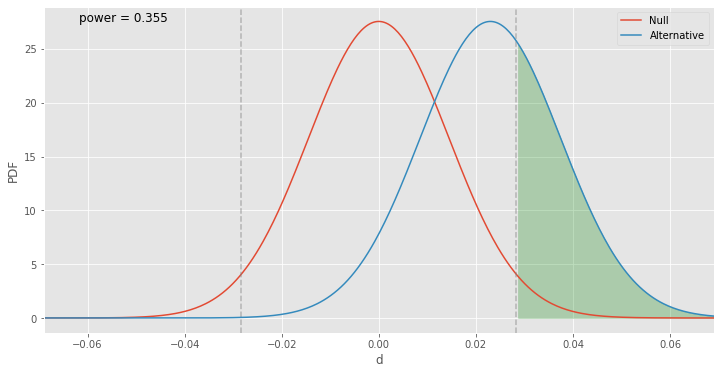

In [26]:
abplot(N_A, N_B, bcr, d_hat, show_power=True)

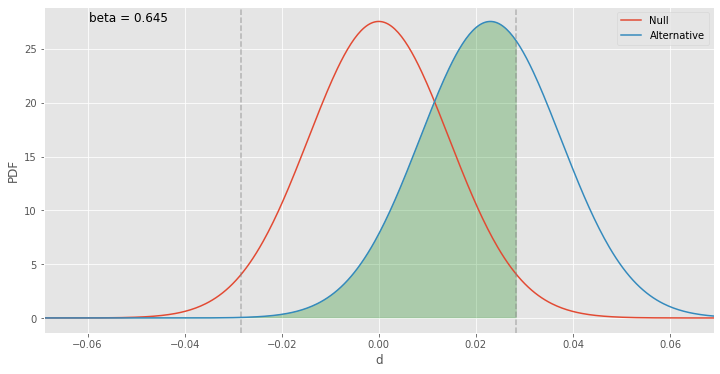

In [27]:
abplot(N_A, N_B, bcr, d_hat, show_beta=True)

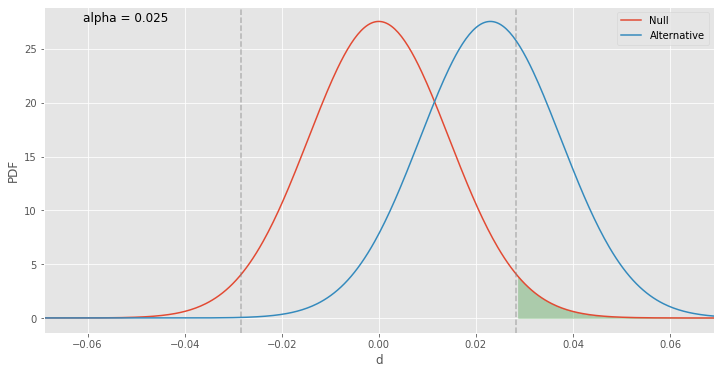

In [28]:
abplot(N_A, N_B, bcr, d_hat, show_alpha=True)

$$ \alpha = 100\% - \text{Confidence Level} $$

In [29]:
bcr, d_hat

(0.10748560460652591, 0.02299456240808788)

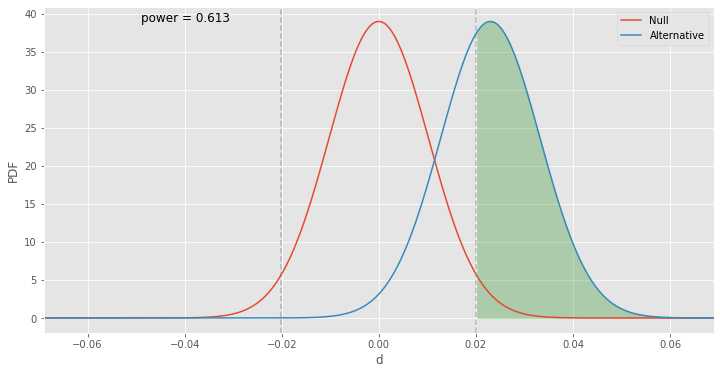

In [30]:
abplot(2000, 2000, bcr, d_hat, show_power=True)

## Calculate the minimum sample size

$$ n = \frac{2(\bar{p})(1-\bar{p})(Z_\beta + Z_{\alpha/2})^2}{(p_B - p_A)^2} $$

$$ Z_\beta : \text{z-score that corresponds to the level of statistical power} $$
$$ Z_{\alpha/2} : \text{z-score that corresponds to the level of significance or confidence level} $$

$$\bar{p}: \text{pooled probability or average of } p_A \text{ and } p_B $$
$$p_A: \text{success rate of control group} $$
$$p_B: \text{success rate of test group} $$

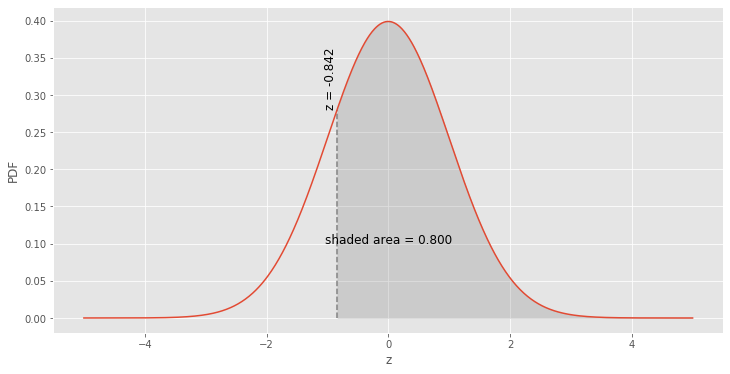

In [31]:
zplot(area=0.80, two_tailed=False, align_right=True)

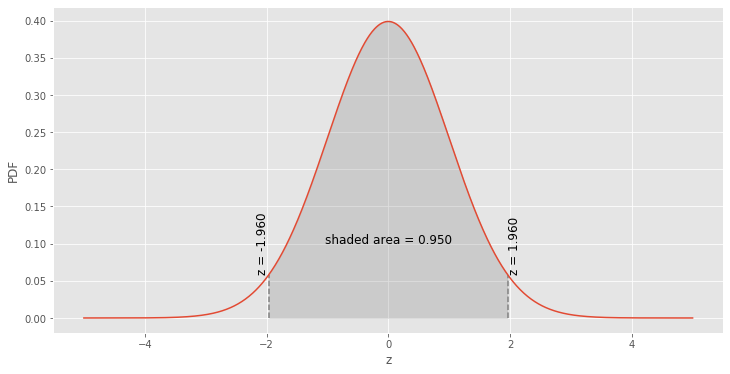

In [32]:
zplot(area=0.95, two_tailed=True)

In [33]:
min_sample_size(bcr=0.10, mde=0.02)

3842.026629963879

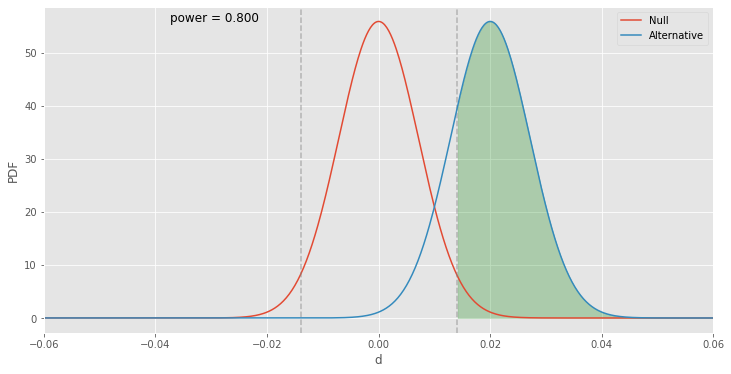

In [34]:
abplot(3843, 3843, 0.10, 0.02, show_power=True)

## Increase the Sample Size

In [0]:
# parameters for generate_data()
N_A = 6000
N_B = 6000
p_A=0.10
p_B=0.12

In [0]:
ab_data = generate_data(N_A, N_B, p_A, p_B)

In [0]:
ab_summary = ab_data.pivot_table(values='converted', index='group', aggfunc=np.sum)
ab_summary['total'] = ab_data.pivot_table(values='converted', index='group', aggfunc=lambda x: len(x))
ab_summary['rate'] = ab_data.pivot_table(values='converted', index='group')

In [38]:
ab_summary

,converted,total,rate
group,,,
A,558,5981,0.093295
B,722,6019,0.119953


In [0]:
# parameters for abplot
n = N_A + N_B
p_A_actual = ab_summary.loc['A', 'rate']
p_B_actual = ab_summary.loc['B', 'rate']
bcr = p_A_actual
d_hat = p_B_actual - p_A_actual

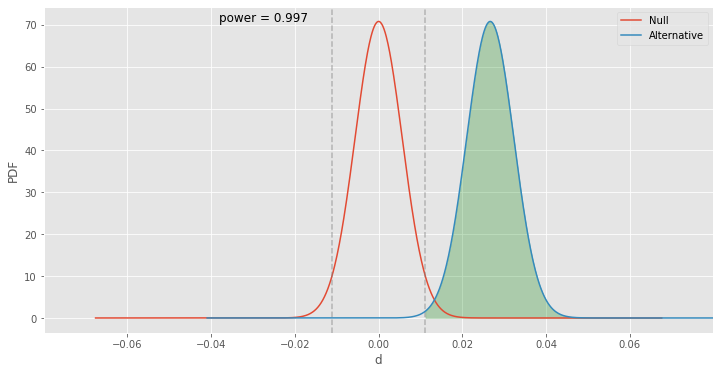

In [40]:
abplot(N_A, N_B, bcr, d_hat, show_power=True)

## Multiple Tests and Funnel Tests

## Confidence Interval Plot

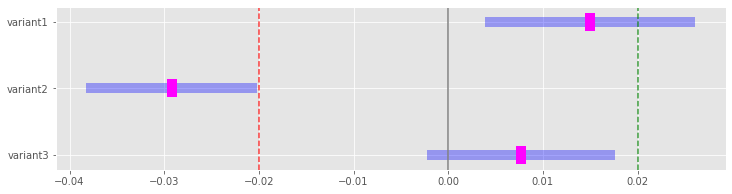

In [41]:
abplot_CI_bars((6000, 6000, 8900, 9100), (600, 690, 630, 980), sig_level=0.05, dmin=0.02)

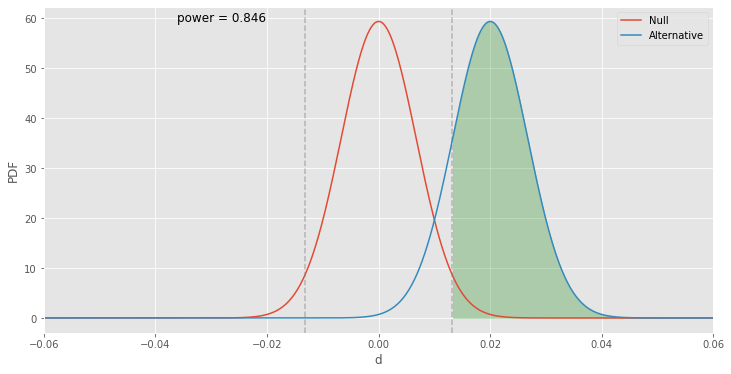

In [42]:
abplot(3000, 9100, 0.10, 0.02, show_power=True)

In [0]:
A = [(10000, 2000), (2000, 200), (300, 40)]
B = [(10000, 2200), (2000, 240), (300, 25)]

[ 0.02  0.02 -0.05]


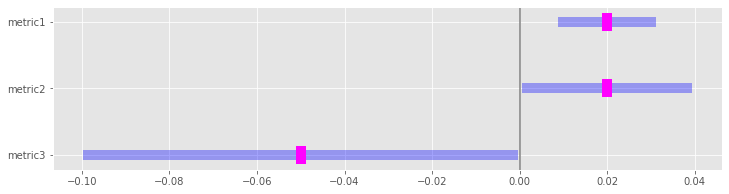

In [44]:
funnel_CI_plot(A, B, sig_level=0.05)